Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Credits

The current notebook has been developed by Dragos Buhnila, based on the initial implementation of Professor Squillero.  
Apart from the initial configuration, the code was written autonomously, with concepts found on the internet but no code ripped off, and some help from github copilot when browsing would take too much.  

In [125]:
from itertools import combinations
from collections import deque
import numpy as np
import random
from geopy.distance import geodesic
import networkx as nx

import pandas as pd
import logging
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from adjustText import adjust_text

from typing import Tuple, Callable

logging.basicConfig(level=logging.INFO)

# Initialization
The actual initialization is done in the "Evolutionary and Genetic Algorithms" paragraph

In [80]:
def init_all_cities() -> Tuple[dict, dict]:
    ALL_CITIES = {}
    ALL_DIST_MATRIX = {}
    countries = []

    for country in os.listdir('cities'):
        if country.endswith('.csv'):
            country = country[:-4]
            countries.append(country)

    for country in countries:
        # Read the CSV file
        ALL_CITIES[country] = pd.read_csv(f'cities/{country}.csv', header=None, names = ['name', 'lat', 'lon'])

        # Calculate distances between all cities
        cur_dist_matrix = np.zeros((len(ALL_CITIES[country]), len(ALL_CITIES[country])))
        for c1, c2 in combinations(ALL_CITIES[country].itertuples(), 2):
            cur_dist_matrix[c1.Index, c2.Index] = cur_dist_matrix[c2.Index, c1.Index] = geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km
        ALL_DIST_MATRIX[country] = cur_dist_matrix

    return ALL_CITIES, ALL_DIST_MATRIX

ALL_CITIES, ALL_DIST_MATRIX = init_all_cities()

# Helper Functions

### General

In [81]:
def tsp_cost(tsp: list[int]) -> float:
    assert tsp[0] != tsp[-1], "in my TSP representation the cycle is implicit, so don't add the last segmenet"
    assert set(tsp) == set(range(len(CITIES))), f"tsp has {len(tsp)} visits out of {len(CITIES)} total cities"
    # logging.debug(f"len(tsp): {len(tsp)}. len(CITIES): {len(CITIES)}")

    # Finally, compute the total cost
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    tot_cost += DIST_MATRIX[tsp[-1], tsp[0]]

    return tot_cost

def tsp_fitness(tsp: list[int]) -> float:
    return -tsp_cost(tsp)

def print_tsp(tsp: list):
    assert tsp[0] != tsp[-1], "in my TSP representation the cycle is implicit, so don't add the last segmenet"

    first = True
    starting_city = tsp[0]
    for city in tsp:
        if first:
            prev_city = city
            first = False
            continue

        logging.info(f"step: {CITIES.at[prev_city,'name']} -> {CITIES.at[city,'name']} ({DIST_MATRIX[prev_city, city]:.2f}km)")
        prev_city = city
    logging.info(f"step: {CITIES.at[city,'name']} -> {CITIES.at[starting_city,'name']} ({DIST_MATRIX[city, starting_city]:.2f}km)")

    logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")



#### Mutations Helper

In [82]:
def swap_mutation(my_individual: list[int]):
    individual = my_individual.copy()

    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
    return individual

def scramble_mutation(my_individual: list[int], strength=0.3):
    individual = my_individual.copy()

    num_elements = int(strength * len(individual))
    if num_elements <= 2:
        num_elements = 2

    indices = random.sample(range(len(individual)), num_elements)
    subset = [individual[i] for i in indices]
    random.shuffle(subset)
    for i, idx in enumerate(indices):
        individual[idx] = subset[i]
    return individual

def insert_mutation(my_individual: list[int]):
    individual = my_individual.copy()

    idx1, idx2 = random.sample(range(len(individual)), 2)
    gene = individual.pop(idx1)
    individual.insert(idx2, gene)
    return individual

def inversion_mutation(my_individual: list[int], strength=0.3):
    individual = my_individual.copy()
    
    num_elements = int(strength * len(individual))
    if num_elements <= 2:
        num_elements = 2

    start_idx = random.randint(0, len(individual) - 1)

    # Create a circular buffer and rotate
    circular_buffer = deque(individual)
    circular_buffer.rotate(-start_idx)

    # Invert the selected number of elements
    subset = list(circular_buffer)[:num_elements]
    subset.reverse()
    for i in range(num_elements):
        circular_buffer[i] = subset[i]

    # Rotate back to the original position and revert to list
    circular_buffer.rotate(start_idx)
    individual[:] = list(circular_buffer)

    return individual

#### Crossover Helper

In [83]:
def cycle_crossover(my_parent1: list[int], my_parent2: list[int]):
    parent1 = my_parent1.copy()
    parent2 = my_parent2.copy()

    size = len(parent1)
    child = [None] * size
    cycle_start = 0

    # Create one cycle. Save the genes of the cycle from parent 1
    complete = False
    while not complete:
        idx = cycle_start
        while True:
            # Copy the gene from parent1 to the child, then go on with the cycle exploration
            child[idx] = parent1[idx]
            idx = parent1.index(parent2[idx])
            # logging.debug(f"{child[idx]}) -> ")
            if idx == cycle_start:
                complete = True
                break
    
    # Fill in the remaining positions with genes from parent2
    for i in range(size):
        if child[i] is None:
            child[i] = parent2[i]
    
    return child

def inver_over_crossover(my_parent1: list[int], my_parent2: list[int]):
    """ This implementation of the inver over refers to the basic version 
        seen in https://www.sciencedirect.com/science/article/pii/S0898122111005530,
        but avoids the mutation chance and just mixes the parents, as I implement mutation separately."""
    parent1 = my_parent1.copy()
    parent2 = my_parent2.copy()
    
    idx1 = random.randint(0, len(parent1) - 1)
    city_i = parent1[idx1]
    idx2 = parent2.index(city_i)
    city_j = parent2[idx2 + 1] if idx2 < len(parent2) - 1 else parent2[0]
    # logging.debug(f"city_i: {city_i} at position {idx1}, city_j: {city_j} at position {idx2}")
    
    # Perform inversion if city_i and city_j are not adjacent
    idx2 = parent1.index(city_j)
    if abs(idx1 - idx2) > 1:
        # Invert the section between the two cities
        if idx1 < idx2:
            parent1[idx1:idx2+1] = reversed(parent1[idx1:idx2+1])
        else:
            parent1[idx2:idx1+1] = reversed(parent1[idx2:idx1+1])
    
    child = parent1
    return child

#### Evolution Helper

In [84]:
def evolve_basic(population, mutation_fn, crossover_fn, 
                 original_fitness, fitness_variabililty, population_size, 
                 epochs, child_mutation_prob, setting_name: str, mutation_fn_param=None):

    population = population.copy() 

    for i in range(epochs + 1):
        new_population = []

        # Generate offspring
        for _ in range(population_size):
            # Select parents
            parent1, parent2 = random.sample(population, 2)
            parent1_genome = parent1[0][:]
            parent2_genome = parent2[0][:]

            # Perform crossover
            child = crossover_fn(parent1_genome, parent2_genome)

            # Additional children based on fitness
            more_children_chance = normalize_fitness(max(parent1[1], parent2[1]), original_fitness, fitness_variabililty, center=0.5)
            more_children_chance = max(0.05, more_children_chance)
            more_children_chance = min(0.9, more_children_chance)

            children = [child]

            while random.random() < more_children_chance:
                # Perform crossover to create additional child
                child = crossover_fn(parent1_genome, parent2_genome)
                children.append(child)

            # Process children
            for child in children:
                child_genome = child[:]  # Ensure a copy
                child_fitness = tsp_fitness(child_genome)

                child_is_better = child_fitness >= parent1[1] or child_fitness >= parent2[1]

                # Apply mutation if needed
                if (not child_is_better) and random.random() < child_mutation_prob:
                    if mutation_fn_param:
                        child_genome = mutation_fn(child_genome, mutation_fn_param)
                    else:
                        child_genome = mutation_fn(child_genome)
                    # Recalculate fitness after mutation
                    child_fitness = tsp_fitness(child_genome)

                new_population.append((child_genome, child_fitness))

        # Combine and sort populations
        population.extend(new_population)
        population = sorted(population, key=lambda x: x[1], reverse=True)
        population = population[:population_size]

        if i % 50 == 0:
            best_fitness = population[0][1]
            recalculated_fitness = tsp_fitness(population[0][0])
            logging.info(f"Epoch {i}: Best fitness: {best_fitness}, recalculated: {recalculated_fitness}. Cost: {tsp_cost(population[0][0])}")
    
    dir = 'tsp_mutations_pickles'
    if not os.path.exists(dir):
        os.makedirs(dir)
    with open(f"{dir}/{setting_name}.pickle", 'wb') as f:
        pickle.dump(population[0], f)

    return population

def normalize_fitness(fitness: float, original_fitness: float, fitness_variabililty: float, center: float = 0.5) -> float:
    """ 
        If worsens then it will go down starting from 0.5 else grow, e.g.:
            > `original_fitness` = -0.3, `fitness` = -0.7 => -0.7 - (-0.3) = -0.4, which is < 0
            > `original_fitness` = -0.7, `fitness` = -0.3 => -0.3 - (-0.7) = 0.4, which is > 0
        Then you apply the division for the `fitness_variability` and center around `center`
    """
    normalized_fitness =  center + ((fitness) - original_fitness) / fitness_variabililty
    return normalized_fitness

# Evolutionary and Genetic Algorithms  
In the following all implementations will use Modern Flow for Genetic Algorithms, except for the last one which uses the Hypermodern Flow. 

Parent selection is binary and uniform, although I feel it would make much more sense using some form of fitness proportional or rankin (I realized too late and now it's too much of a hassle).  

Recombination uses the functions which can be seen in the helper in all the possible combinations. There's a normalized fitness proportional chance of 2 parents having more children.  

Mutation happens in children with a fixed probability, but only if they didn't already improve the parents' fitness.  

The algorithm is steady state, and survivor selection based on linear ranking.  

In [85]:
def initialize(country: str):
    CITIES = ALL_CITIES[country]
    DIST_MATRIX = ALL_DIST_MATRIX[country]

    return CITIES, DIST_MATRIX

COUNTRY = 'italy'
CITIES, DIST_MATRIX = initialize(COUNTRY)

logging.info(f'Loaded {len(CITIES)} cities from {COUNTRY}')

INFO:root:Loaded 46 cities from italy


## Starting From A Greedy Solution (Single Individual)
The following solutions will start from a population derived from somewhat wide mutations of Greedy Solution #2.

In the following I will use scramble and inversion as mutations because I feel like others may prove too small of a variation, since we are starting to mutate from just one solution. Inversion may not be enough actually but I'll try. (maybe I'll try with small mutations too later)

Inversion doesn't seem to make sense with inner over, as the chances of mantaining adjacency is high with Inversion.  

Understanding how the various algorithms work takes enough time to not allow me to explore them all, so I'll stick with Inver Over (because it's the one used in the best tsp solution ever recorded) and Cycle (because I dind't manage to study Partially Mapped Crossover too).

#### Create the population

In [86]:
starting_mutations_composition = {swap_mutation: 0.82,
                                  scramble_mutation: 0.06,
                                  inversion_mutation: 0.06,
                                  insert_mutation: 0.06}

with open(f'./tsp_pickles/{COUNTRY}_tsp_greedy2.pkl', 'rb') as file:
    tsp = pickle.load(file)
    tsp = tsp[:-1]  # Remove the last city, as it is the same as the first

# Initialize the population
population_size = 1000
original_population = [tsp]
# logging.debug(f"Starting tsp:    {tsp}")

# Generate the initial population
for mutation, strength in starting_mutations_composition.items():
    for _ in range(int(population_size * strength)):
        individual = tsp.copy()
        individual = mutation(individual)
        original_population.append(individual)
original_population = original_population[:population_size]

# Calculate fitness for all individuals and save original and variability
original_population = [(x, tsp_fitness(x)) for x in original_population]
original_population = sorted(original_population, key=lambda x: x[1], reverse=True)
original_fitness = original_population[0][1]
fitness_variabililty = original_population[0][1] - original_population[-1][1]

logging.info(f"Generated initial population of {len(original_population)} individuals")
logging.info(f"Initial population:")
for i, individual in enumerate(original_population):
    if i % 1 == 0:
        logging.debug(f"{i:5d}) {individual}")

# logging.debug(f"Original fitness: {original_fitness}. Recalculated: {tsp_fitness(original_population[0][0])}. And cost: {tsp_cost(original_population[0][0])}")


INFO:root:Generated initial population of 1000 individuals
INFO:root:Initial population:
DEBUG:root:    0) ([27, 21, 35, 11, 1, 2, 38, 14, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4689.17543824674))
DEBUG:root:    1) ([14, 21, 35, 11, 1, 2, 38, 27, 37, 8, 31, 17, 24, 7, 36, 16, 10, 29, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4723.649164328661))
DEBUG:root:    2) ([14, 21, 35, 11, 1, 38, 2, 27, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4726.685848729144))
DEBUG:root:    3) ([14, 21, 35, 11, 1, 2, 27, 38, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4728.098861363511))
DEBU

DEBUG:root:    5) ([14, 21, 35, 11, 1, 2, 38, 27, 31, 8, 37, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4736.716332690186))
DEBUG:root:    6) ([14, 21, 35, 38, 1, 2, 11, 27, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4739.577194922931))
DEBUG:root:    7) ([14, 21, 35, 11, 1, 2, 38, 27, 37, 8, 17, 31, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 26, 39, 34, 15], np.float64(-4741.532154269583))
DEBUG:root:    8) ([14, 21, 35, 11, 1, 2, 38, 27, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5, 41, 43, 23, 45, 44, 6, 3, 20, 18, 22, 42, 13, 28, 25, 32, 19, 4, 9, 12, 30, 33, 0, 26, 39, 34, 15], np.float64(-4742.48144248169))
DEBUG:root:    9) ([14, 21, 35, 11, 1, 2, 38, 27, 37, 8, 31, 17, 24, 7, 36, 16, 29, 10, 40, 5

### Scramble + Inver Over  

In [87]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = scramble_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_greedy_scramble_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -4689.17543824674, recalculated: -4689.17543824674. Cost: 4689.17543824674


INFO:root:Epoch 50: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 100: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 150: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 200: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 250: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 300: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 350: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 400: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 4410.850640346449
INFO:root:Epoch 450: Best fitness: -4410.850640346449, recalculated: -4410.850640346449. Cost: 44

#### Swap + Inver Over

In [88]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = swap_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_greedy_swap_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -4640.522468527384, recalculated: -4640.522468527384. Cost: 4640.522468527384
INFO:root:Epoch 50: Best fitness: -4398.180668567251, recalculated: -4398.180668567251. Cost: 4398.180668567251
INFO:root:Epoch 100: Best fitness: -4290.851920578198, recalculated: -4290.851920578198. Cost: 4290.851920578198
INFO:root:Epoch 150: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286.183918990257
INFO:root:Epoch 200: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286.183918990257
INFO:root:Epoch 250: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286.183918990257
INFO:root:Epoch 300: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286.183918990257
INFO:root:Epoch 350: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286.183918990257
INFO:root:Epoch 400: Best fitness: -4286.183918990257, recalculated: -4286.183918990257. Cost: 4286

### Scramble + Cycle

In [89]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = scramble_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_greedy_scramble_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -4689.17543824674, recalculated: -4689.17543824674. Cost: 4689.17543824674
INFO:root:Epoch 50: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 100: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 150: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 200: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 250: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 300: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 350: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 400: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.77

### Inversion + Cycle

In [90]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = inversion_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_greedy_inversion_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -4689.17543824674, recalculated: -4689.17543824674. Cost: 4689.17543824674
INFO:root:Epoch 50: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 100: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 150: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 200: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 250: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 300: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 350: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.772268778574
INFO:root:Epoch 400: Best fitness: -4682.772268778574, recalculated: -4682.772268778574. Cost: 4682.77

## Starting From Random Population

In [91]:
population_size = 1000

starting_vector = list(range(len(CITIES)))
random.shuffle(starting_vector)

# Create 1000 individuals, shuffle each of them, and make them into a tuple with their fitness
original_population = [starting_vector.copy() for _ in range(population_size)]
for individual in original_population: individual = random.shuffle(individual)
original_population = [(x, tsp_fitness(x)) for x in original_population]

logging.info(f"Generated initial population of {len(original_population)} individuals")
logging.info(f"Initial population:")
for i, individual in enumerate(original_population):
    if i % 100 == 0:
        logging.debug(f"{i:5d}) {individual}")

INFO:root:Generated initial population of 1000 individuals
INFO:root:Initial population:
DEBUG:root:    0) ([22, 27, 44, 28, 21, 11, 10, 14, 40, 13, 32, 20, 3, 19, 39, 16, 45, 33, 7, 35, 8, 37, 0, 25, 15, 5, 31, 23, 26, 41, 24, 42, 1, 34, 38, 36, 12, 6, 18, 9, 2, 17, 43, 30, 29, 4], np.float64(-18235.612156493673))
DEBUG:root:  100) ([21, 39, 10, 25, 17, 32, 12, 24, 35, 13, 2, 22, 4, 38, 34, 6, 37, 30, 27, 45, 15, 14, 8, 33, 7, 44, 1, 23, 42, 36, 19, 31, 40, 43, 20, 0, 41, 28, 11, 5, 26, 29, 16, 9, 18, 3], np.float64(-21523.236752490116))
DEBUG:root:  200) ([17, 36, 43, 39, 0, 23, 25, 22, 41, 4, 34, 45, 11, 14, 10, 8, 6, 33, 44, 20, 2, 24, 38, 27, 16, 28, 18, 15, 32, 5, 40, 26, 35, 29, 3, 31, 9, 12, 7, 19, 42, 1, 21, 30, 37, 13], np.float64(-19679.96720279403))
DEBUG:root:  300) ([24, 42, 30, 25, 34, 23, 12, 16, 27, 13, 21, 37, 14, 19, 41, 28, 5, 18, 40, 15, 11, 31, 8, 39, 35, 36, 29, 17, 26, 38, 7, 3, 6, 20, 9, 2, 33, 44, 22, 0, 1, 45, 10, 4, 43, 32], np.float64(-17213.44306653256))
D

### Swap + Cycle

In [92]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = swap_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_swap_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14478.239179540935, recalculated: -14478.239179540935. Cost: 14478.239179540935
INFO:root:Epoch 50: Best fitness: -9298.796525913558, recalculated: -9298.796525913558. Cost: 9298.796525913558
INFO:root:Epoch 100: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 150: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 200: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 250: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 300: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 350: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8796.065224150487
INFO:root:Epoch 400: Best fitness: -8796.065224150487, recalculated: -8796.065224150487. Cost: 8

### Swap + Inver Over

In [93]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = swap_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_swap_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14465.048961102526, recalculated: -14465.048961102526. Cost: 14465.048961102526
INFO:root:Epoch 50: Best fitness: -8832.787066534001, recalculated: -8832.787066534001. Cost: 8832.787066534001
INFO:root:Epoch 100: Best fitness: -6442.803505684946, recalculated: -6442.803505684946. Cost: 6442.803505684946
INFO:root:Epoch 150: Best fitness: -5547.490845930767, recalculated: -5547.490845930767. Cost: 5547.490845930767
INFO:root:Epoch 200: Best fitness: -5154.924755125485, recalculated: -5154.924755125485. Cost: 5154.924755125485
INFO:root:Epoch 250: Best fitness: -5036.621779192442, recalculated: -5036.621779192442. Cost: 5036.621779192442
INFO:root:Epoch 300: Best fitness: -5020.326862682105, recalculated: -5020.326862682105. Cost: 5020.326862682105
INFO:root:Epoch 350: Best fitness: -4950.280689500503, recalculated: -4950.280689500503. Cost: 4950.280689500503
INFO:root:Epoch 400: Best fitness: -4950.280689500503, recalculated: -4950.280689500503. Cost: 4

### Scramble + Cycle

In [94]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = scramble_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_scramble_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -13973.8523015966, recalculated: -13973.8523015966. Cost: 13973.8523015966
INFO:root:Epoch 50: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 100: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 150: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 200: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 250: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 300: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 350: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.694327216404
INFO:root:Epoch 400: Best fitness: -8222.694327216404, recalculated: -8222.694327216404. Cost: 8222.69

### Scramble + Inver Over

In [95]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = scramble_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_scramble_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14478.239179540935, recalculated: -14478.239179540935. Cost: 14478.239179540935
INFO:root:Epoch 50: Best fitness: -8407.044143664525, recalculated: -8407.044143664525. Cost: 8407.044143664525
INFO:root:Epoch 100: Best fitness: -6475.943103854065, recalculated: -6475.943103854065. Cost: 6475.943103854065
INFO:root:Epoch 150: Best fitness: -5616.677663626214, recalculated: -5616.677663626214. Cost: 5616.677663626214
INFO:root:Epoch 200: Best fitness: -5456.934596779817, recalculated: -5456.934596779817. Cost: 5456.934596779817
INFO:root:Epoch 250: Best fitness: -5456.934596779817, recalculated: -5456.934596779817. Cost: 5456.934596779817
INFO:root:Epoch 300: Best fitness: -5456.934596779817, recalculated: -5456.934596779817. Cost: 5456.934596779817
INFO:root:Epoch 350: Best fitness: -5456.934596779817, recalculated: -5456.934596779817. Cost: 5456.934596779817
INFO:root:Epoch 400: Best fitness: -5456.934596779817, recalculated: -5456.934596779817. Cost: 5

### Insert + Cycle

In [96]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = insert_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_insert_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14301.531822009265, recalculated: -14301.531822009265. Cost: 14301.531822009265
INFO:root:Epoch 50: Best fitness: -8506.71079864101, recalculated: -8506.71079864101. Cost: 8506.71079864101
INFO:root:Epoch 100: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 150: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 200: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 250: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 300: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 350: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707.191194160339
INFO:root:Epoch 400: Best fitness: -7707.191194160339, recalculated: -7707.191194160339. Cost: 7707

### Insert + Inver Over

In [97]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = insert_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_insert_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14478.239179540935, recalculated: -14478.239179540935. Cost: 14478.239179540935
INFO:root:Epoch 50: Best fitness: -8130.483930030145, recalculated: -8130.483930030145. Cost: 8130.483930030145
INFO:root:Epoch 100: Best fitness: -5576.854068235852, recalculated: -5576.854068235852. Cost: 5576.854068235852
INFO:root:Epoch 150: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4614.292570659508
INFO:root:Epoch 200: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4614.292570659508
INFO:root:Epoch 250: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4614.292570659508
INFO:root:Epoch 300: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4614.292570659508
INFO:root:Epoch 350: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4614.292570659508
INFO:root:Epoch 400: Best fitness: -4614.292570659508, recalculated: -4614.292570659508. Cost: 4

### Inversion + Cycle

In [98]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = cycle_crossover
do_mutation = inversion_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_inversion_cycle")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14478.239179540935, recalculated: -14478.239179540935. Cost: 14478.239179540935
INFO:root:Epoch 50: Best fitness: -7229.399930352842, recalculated: -7229.399930352842. Cost: 7229.399930352842
INFO:root:Epoch 100: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 150: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 200: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 250: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 300: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 350: Best fitness: -6575.4927651697635, recalculated: -6575.4927651697635. Cost: 6575.4927651697635
INFO:root:Epoch 400: Best fitness: -6575.4927651697635, recalculated: -6575.49

### Inversion + Inver Over

In [99]:
child_mutation_prob = 0.5
epochs = 1000
do_crossover = inver_over_crossover
do_mutation = inversion_mutation

population = evolve_basic(original_population, do_mutation, do_crossover, 
                    original_fitness, fitness_variabililty, population_size, 
                    epochs, child_mutation_prob, f"{COUNTRY}_random_inversion_inverover")

if population[0][1] == original_fitness:
    logging.info(f"No improvement found from the initial greedy solution ({original_fitness})")
else:
    print_tsp(population[0][0])

INFO:root:Epoch 0: Best fitness: -14300.380101163377, recalculated: -14300.380101163377. Cost: 14300.380101163377
INFO:root:Epoch 50: Best fitness: -8139.800799884766, recalculated: -8139.800799884766. Cost: 8139.800799884766
INFO:root:Epoch 100: Best fitness: -6469.4872750577415, recalculated: -6469.4872750577415. Cost: 6469.4872750577415
INFO:root:Epoch 150: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost: 6106.767989867114
INFO:root:Epoch 200: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost: 6106.767989867114
INFO:root:Epoch 250: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost: 6106.767989867114
INFO:root:Epoch 300: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost: 6106.767989867114
INFO:root:Epoch 350: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost: 6106.767989867114
INFO:root:Epoch 400: Best fitness: -6106.767989867114, recalculated: -6106.767989867114. Cost

## Findings
When starting from a decent solution, inver-over outperforms cycle, while it performs extremely poorly when starting from a random population.

Even though they perform worse on random population starts, inver-over solutions actually seem to grow more steadily than cycle solutions, although at an abysmally slow rate. Testing higher values for the epochs seems to testify that, but my computing capabilities won't allow me to increase time and space enough to find results being on par or better than the cycle solutions.

Another clear finding is that the greedy solutions were really good, and we can't really equal their efficiency using my simple evolution implementations, but we can increase their results slightly using inver over, for which swapping proved to be the best mutation coupling.  

DEBUG:root:italy_greedy_inversion_cycle.pickle: -4682.772268778574
DEBUG:adjustText:Auto-explode radius: 213.08928571428572
DEBUG:adjustText:0
DEBUG:adjustText:1
DEBUG:adjustText:2
DEBUG:adjustText:3
DEBUG:adjustText:4
DEBUG:adjustText:5
DEBUG:adjustText:6
DEBUG:adjustText:7
DEBUG:adjustText:8
DEBUG:adjustText:9
DEBUG:adjustText:10
DEBUG:adjustText:11
DEBUG:adjustText:12
DEBUG:adjustText:13
DEBUG:adjustText:14
DEBUG:adjustText:15
DEBUG:adjustText:16
DEBUG:adjustText:17
DEBUG:adjustText:18
DEBUG:adjustText:19
DEBUG:adjustText:20
DEBUG:adjustText:21
DEBUG:adjustText:22
DEBUG:adjustText:23
DEBUG:adjustText:24
DEBUG:adjustText:25
DEBUG:adjustText:26
DEBUG:adjustText:27
DEBUG:adjustText:28
DEBUG:adjustText:29
DEBUG:adjustText:30
DEBUG:adjustText:31
DEBUG:adjustText:32
DEBUG:adjustText:33
DEBUG:adjustText:Removing crossing at step 33: 1 and 0
DEBUG:adjustText:Segments: [537.62019231 190.74508227 257.30769231 165.24508227] and [310.0625     169.74508227 192.27272727 165.24508227]
DEBUG:adjust

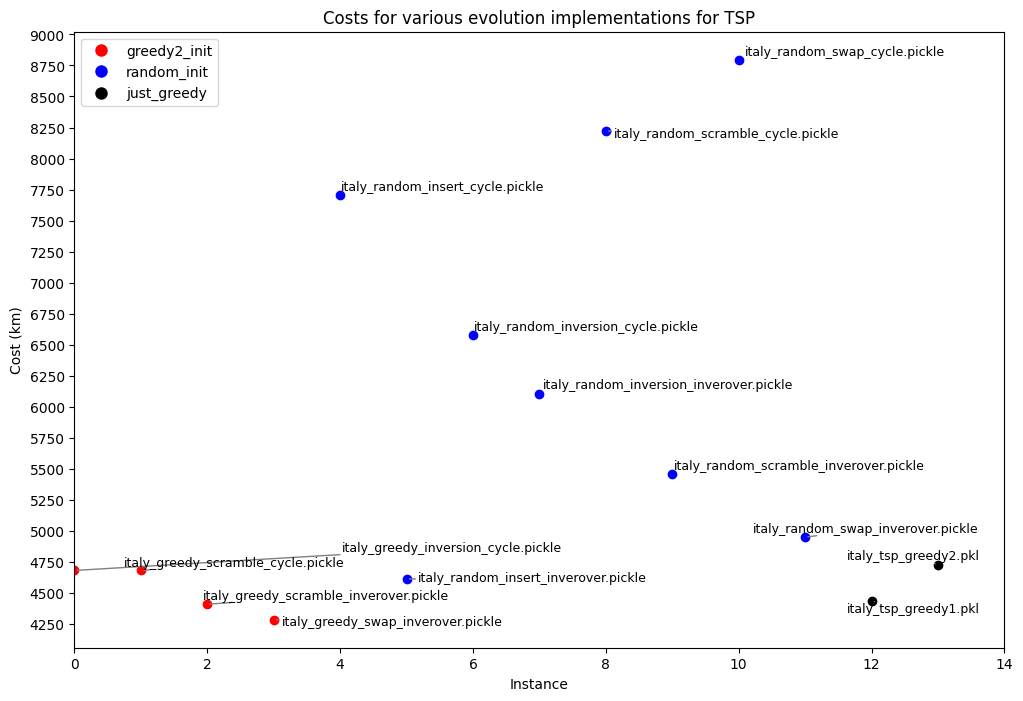

In [141]:
def load_all_pkl_files():
    directory = './tsp_mutations_pickles'

    # Take only files containing .pickle
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pickle')]
    pkl_files = [f for f in pkl_files if COUNTRY in f]

    # Load all the data
    data = {}
    for pkl_file in pkl_files:
        with open(os.path.join(directory, pkl_file), 'rb') as file:
            data[pkl_file] = pickle.load(file)
    return data

def load_greedy_solutions():
    directory = './tsp_pickles'
    
    # Take only files containing .pkl and greedy and COUNTRY
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    pkl_files = [f for f in pkl_files if 'greedy' in f]
    pkl_files = [f for f in pkl_files if COUNTRY in f]

    # Load all the data
    data = {}
    for pkl_file in pkl_files:
        with open(os.path.join(directory, pkl_file), 'rb') as file:
            data[pkl_file] = pickle.load(file)
    return data

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


mutation_data = load_all_pkl_files() # This is a dictionary containing (tsps, fitness) as values
greedy_data = load_greedy_solutions() # This is a dictionary containing just tsps as values

name, content = list(mutation_data.items())[0]
logging.debug(f"{name}: {content[1]}")

plt.figure(figsize=(12, 8))

# Define the legend patches
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='greedy2_init')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='random_init')
black_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10, label='just_greedy')

# Plot the scatter points
i = 0
texts = []
max_cost = 0
min_cost = 1e9
for name, (tsp, fitness) in mutation_data.items():
    cost = -fitness
    max_cost = max(max_cost, cost)
    min_cost = min(min_cost, cost)

    color = 'r' if 'greedy' in name else 'b'

    plt.scatter(i, cost, color=color)
    text = plt.text(i, cost, name, fontsize=9)
    texts.append(text)
    i += 1

for name, tsp in greedy_data.items():
    cost = tsp_cost(tsp[:-1])
    max_cost = max(max_cost, cost)
    min_cost = min(min_cost, cost)

    plt.scatter(i, cost, color='k')
    text = plt.text(i, cost, name, fontsize=9)
    texts.append(text)
    i += 1

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), )

# Set the limits for the x and y axes
plt.xlim(0, i)

# Increase granularity of the y-axis
step = 250
y_ticks = [i for i in range(int(min_cost) - step, int(max_cost) + step) if i % step == 0]
plt.yticks(y_ticks)

# Add the legend patches
plt.legend(handles=[red_patch, blue_patch, black_patch])
plt.ylabel('Cost (km)')
plt.xlabel('Instance')
plt.title('Costs for various evolution implementations for TSP')
plt.show()